In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)
measurement_data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# find out MAX date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
max_date = dt.datetime.strptime(last_date, "%Y-%m-%d")


# Calculate the date one year from the last date in data set.
last_year = max_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
prcp_results = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date > last_year)
    .order_by(Measurement.date)
    .all()
)


# Save the query results as a Pandas DataFrame
temp_df = pd.DataFrame(prcp_results, columns=["Date", "Precipitation"])


# Sort the dataframe by date, drop all NULL values and set the index to the date column
prcp_df = temp_df.sort_values("Date").dropna().set_index("Date")
prcp_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


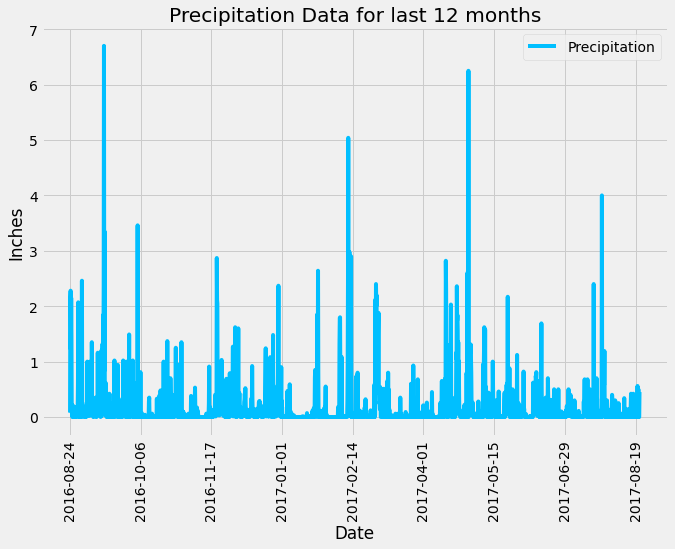

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(color="deepskyblue", figsize=(10, 7))
plt.xticks(rotation=90)
plt.title("Precipitation Data for last 12 months")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.savefig("Precipitation_Data.png")


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
station_data = pd.read_sql("SELECT * FROM station", conn)
station_data

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [15]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.station).count()

print(f"Number of Stations = {station_count}")

Number of Stations = 9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = (
    session.query(Measurement.station, Station.name, func.count(Measurement.station))
    .filter(Measurement.station == Station.station)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

active_stations_df = pd.DataFrame(active_stations, columns=["Station", "Name", "Count"])
active_stations_df

,Station,Name,Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == active_stations_df['Station'][0])
    .all()
)

print(
    f"The Most active station is {active_stations_df['Station'][0]} ({active_stations_df['Name'][0]}). Following are its stats:"
)
print(f"Lowest Temperature: {station_stats[0][0]} F")
print(f"Highest Temperature: {station_stats[0][1]} F")
print(f"Average Temperature: {station_stats[0][2]} F")

The Most active station is USC00519281 (WAIHEE 837.5, HI US). Following are its stats:
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
active_results = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.date > last_year)
    .filter(Measurement.station == active_stations_df['Station'][0])
    .order_by(Measurement.date)
    .all()  
)

active_df = pd.DataFrame(active_results)
active_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


In [19]:
final_active_df = active_df.set_index("date")
final_active_df.head()

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


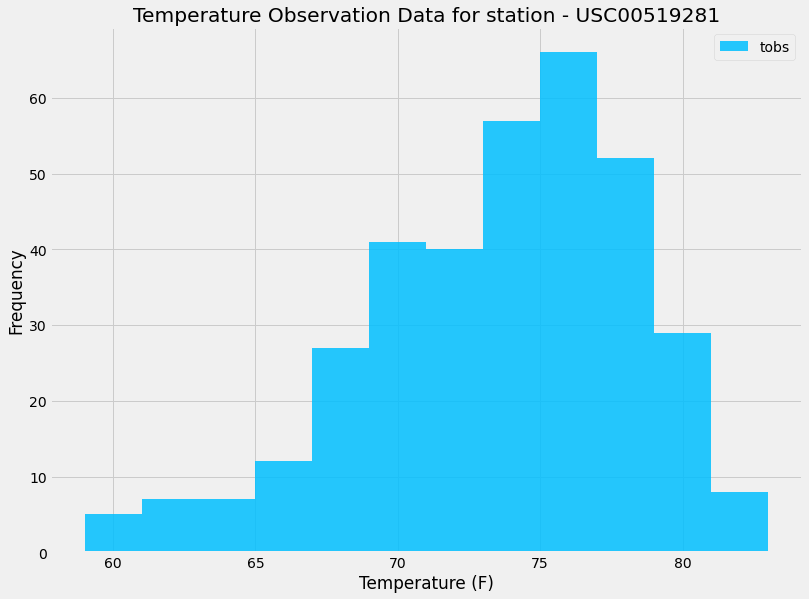

In [20]:
# plot the results as a histogram
final_active_df.plot(kind="hist", color="deepskyblue", bins=12, alpha=0.85, figsize=(12, 9))
plt.title(f"Temperature Observation Data for station - {active_stations_df['Station'][0]}")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.savefig("TOB_Hist.png")

# Close session

In [21]:
# Close Session
session.close()